## How does everything interact with everthing?!!

In [575]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler ,minmax_scale



### imported my imputed X and y

imputation was based on research I conducted with a classmate using zillow. All of the bedbaths that had 0 were not actually 0. The mean bed bath of the 12 houses we looked at was not signeficantly different to the population mean so we imputed those values. 

In addition, there was 1 house with 33 bedrooms, after looking the house up I concluded that it actually has 3 bedrooms so i changed it's value

In [451]:
df = pd.read_csv('../cleanedData/X.imputed.csv', index_col=0)
y = pd.read_csv('../raw/y.csv')

In [483]:
df.shape[0]**0.5

131.49144458861193

# Dropping columns

Things like year built

In [453]:
to_drop = [
    'id', # arbitrary/random. Removed. 
    'date', # Adding polynomial week into the model, the rest handled by seasonality
    'zipcode', # overall the model improves, handled in dummy colums
#    'sqft_basement', # Left it in, the interaction between basement and other columns is important
#     'yr_renovated'
]

In [454]:
df.drop(columns=to_drop, inplace=True)

In [455]:
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,47.4388,-122.162,2390,7700
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,47.6784,-122.285,2370,6283
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,47.5646,-122.129,3710,9685
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,47.6995,-122.228,4050,14226
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,47.6647,-122.083,2250,4050


## Multiply everything with everything

### change yr_built to house age and yr_renovated to age

In [456]:
df.yr_built = df.yr_built.apply(lambda x: 2015-x)
df.yr_renovated = df.yr_renovated.apply(lambda x: 2015-x)

In [457]:
len(set(list(itertools.permutations(df.columns,2))))

272

In [458]:
def get_interactions(df, choose=2):
    """
    df --> pd.seriesdataframe
    returns --> pd.dataframe
    
    Given a dataframe, this function takes all of the columns and generates an a new column based on their
    multiplicative interaction.
    
    dependent on itertools and pandas
    """
    columns = itertools.permutations(df.columns,choose)
    interaction = {' X '.join(x): df[x[0]]*df[x[0]] for x in columns}
    return pd.DataFrame.from_dict(interaction)

In [459]:
interaction_df = get_interactions(df)


In [460]:
interaction_df.head()

,bedrooms X bathrooms,bedrooms X sqft_living,bedrooms X sqft_lot,bedrooms X floors,bedrooms X waterfront,bedrooms X view,bedrooms X condition,bedrooms X grade,bedrooms X sqft_above,bedrooms X sqft_basement,...,sqft_lot15 X view,sqft_lot15 X condition,sqft_lot15 X grade,sqft_lot15 X sqft_above,sqft_lot15 X sqft_basement,sqft_lot15 X yr_built,sqft_lot15 X yr_renovated,sqft_lot15 X lat,sqft_lot15 X long,sqft_lot15 X sqft_living15
0,16,16,16,16,16,16,16,16,16,16,...,59290000,59290000,59290000,59290000,59290000,59290000,59290000,59290000,59290000,59290000
1,25,25,25,25,25,25,25,25,25,25,...,39476089,39476089,39476089,39476089,39476089,39476089,39476089,39476089,39476089,39476089
2,16,16,16,16,16,16,16,16,16,16,...,93799225,93799225,93799225,93799225,93799225,93799225,93799225,93799225,93799225,93799225
3,9,9,9,9,9,9,9,9,9,9,...,202379076,202379076,202379076,202379076,202379076,202379076,202379076,202379076,202379076,202379076
4,9,9,9,9,9,9,9,9,9,9,...,16402500,16402500,16402500,16402500,16402500,16402500,16402500,16402500,16402500,16402500


# Removed one of the features to avoid colinearity

In [461]:
interaction_df.iloc[:,:-1]

,bedrooms X bathrooms,bedrooms X sqft_living,bedrooms X sqft_lot,bedrooms X floors,bedrooms X waterfront,bedrooms X view,bedrooms X condition,bedrooms X grade,bedrooms X sqft_above,bedrooms X sqft_basement,...,sqft_lot15 X waterfront,sqft_lot15 X view,sqft_lot15 X condition,sqft_lot15 X grade,sqft_lot15 X sqft_above,sqft_lot15 X sqft_basement,sqft_lot15 X yr_built,sqft_lot15 X yr_renovated,sqft_lot15 X lat,sqft_lot15 X long
0,16,16,16,16,16,16,16,16,16,16,...,59290000,59290000,59290000,59290000,59290000,59290000,59290000,59290000,59290000,59290000
1,25,25,25,25,25,25,25,25,25,25,...,39476089,39476089,39476089,39476089,39476089,39476089,39476089,39476089,39476089,39476089
2,16,16,16,16,16,16,16,16,16,16,...,93799225,93799225,93799225,93799225,93799225,93799225,93799225,93799225,93799225,93799225
3,9,9,9,9,9,9,9,9,9,9,...,202379076,202379076,202379076,202379076,202379076,202379076,202379076,202379076,202379076,202379076
4,9,9,9,9,9,9,9,9,9,9,...,16402500,16402500,16402500,16402500,16402500,16402500,16402500,16402500,16402500,16402500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,25,25,25,25,25,25,25,25,25,25,...,108160000,108160000,108160000,108160000,108160000,108160000,108160000,108160000,108160000,108160000
17286,4,4,4,4,4,4,4,4,4,4,...,16104169,16104169,16104169,16104169,16104169,16104169,16104169,16104169,16104169,16104169
17287,9,9,9,9,9,9,9,9,9,9,...,88416409,88416409,88416409,88416409,88416409,88416409,88416409,88416409,88416409,88416409
17288,9,9,9,9,9,9,9,9,9,9,...,11670048784,11670048784,11670048784,11670048784,11670048784,11670048784,11670048784,11670048784,11670048784,11670048784


In [462]:
# Create data frame with original columns plus all interactions
X = pd.concat([df, interaction_df.iloc[:,:-1]], axis=1)
y = pd.read_csv('../raw/y.csv', header=None)
y.columns=['price']


In [463]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,sqft_lot15 X waterfront,sqft_lot15 X view,sqft_lot15 X condition,sqft_lot15 X grade,sqft_lot15 X sqft_above,sqft_lot15 X sqft_basement,sqft_lot15 X yr_built,sqft_lot15 X yr_renovated,sqft_lot15 X lat,sqft_lot15 X long
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,...,59290000,59290000,59290000,59290000,59290000,59290000,59290000,59290000,59290000,59290000
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,...,39476089,39476089,39476089,39476089,39476089,39476089,39476089,39476089,39476089,39476089
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,...,93799225,93799225,93799225,93799225,93799225,93799225,93799225,93799225,93799225,93799225
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,...,202379076,202379076,202379076,202379076,202379076,202379076,202379076,202379076,202379076,202379076
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,...,16402500,16402500,16402500,16402500,16402500,16402500,16402500,16402500,16402500,16402500


## Polynomial Transformations

In [464]:
# Week
df = pd.read_csv('../cleanedData/X.imputed.csv', index_col=0)
week = pd.to_datetime(df.date)
X['week'] = week.dt.strftime("%W").astype(int)
X['week^2'] = X.week**2
X['week^3'] = X.week**3


##  Non Linear Transformation

In [465]:
# log cont. variables
X.sqft_living = np.log(X.sqft_living)
X.sqft_living = np.log(X.sqft_lot)
X.sqft_above = np.log(X.sqft_above)


In [466]:
# Year renovated and sqft_basement are currently in the dataframe. Meaning we have their interations too
X.columns.to_list()

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'bedrooms X bathrooms',
 'bedrooms X sqft_living',
 'bedrooms X sqft_lot',
 'bedrooms X floors',
 'bedrooms X waterfront',
 'bedrooms X view',
 'bedrooms X condition',
 'bedrooms X grade',
 'bedrooms X sqft_above',
 'bedrooms X sqft_basement',
 'bedrooms X yr_built',
 'bedrooms X yr_renovated',
 'bedrooms X lat',
 'bedrooms X long',
 'bedrooms X sqft_living15',
 'bedrooms X sqft_lot15',
 'bathrooms X bedrooms',
 'bathrooms X sqft_living',
 'bathrooms X sqft_lot',
 'bathrooms X floors',
 'bathrooms X waterfront',
 'bathrooms X view',
 'bathrooms X condition',
 'bathrooms X grade',
 'bathrooms X sqft_above',
 'bathrooms X sqft_basement',
 'bathrooms X yr_built',
 'bathrooms X yr_renovated',
 'bathrooms X lat',
 'bathrooms X long',
 'bathrooms X sqft_living15',
 '

In [467]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [468]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_hat)
RMSE**0.5

179792.96031274536

In [469]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
(cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10))

array([0.62643602, 0.71089107, 0.79391608, 0.71122   , 0.76530289,
       0.77280028, 0.73970805, 0.75849608, 0.73437696, 0.75194961])

## Now that we have a model with all of the interaction features, we can concatenate it with the all of our geospatial features time series features

In [470]:
# X_full_model_one has all of our geospatial and time data in it
X_full_model_one = pd.read_csv('../raw/X_full_model_one.csv', index_col=0)

In [471]:
# first 21 features are repeated in our X dataframe so we can drop them
list(enumerate(list(X_full_model_one.columns)))

[(0, 'id'),
 (1, 'date'),
 (2, 'bedrooms'),
 (3, 'bathrooms'),
 (4, 'sqft_living'),
 (5, 'sqft_lot'),
 (6, 'floors'),
 (7, 'waterfront'),
 (8, 'view'),
 (9, 'condition'),
 (10, 'grade'),
 (11, 'sqft_above'),
 (12, 'sqft_basement'),
 (13, 'yr_built'),
 (14, 'yr_renovated'),
 (15, 'zipcode'),
 (16, 'lat'),
 (17, 'long'),
 (18, 'sqft_living15'),
 (19, 'sqft_lot15'),
 (20, 'c22uz'),
 (21, 'c22vm'),
 (22, 'c22vn'),
 (23, 'c22vp'),
 (24, 'c22vr'),
 (25, 'c22vs'),
 (26, 'c22vt'),
 (27, 'c22vu'),
 (28, 'c22vv'),
 (29, 'c22vw'),
 (30, 'c22vz'),
 (31, 'c22yj'),
 (32, 'c22yp'),
 (33, 'c22yq'),
 (34, 'c22yr'),
 (35, 'c22yw'),
 (36, 'c22yx'),
 (37, 'c22yy'),
 (38, 'c22yz'),
 (39, 'c22zn'),
 (40, 'c22zp'),
 (41, 'c22zq'),
 (42, 'c22zr'),
 (43, 'c22zx'),
 (44, 'c22zy'),
 (45, 'c22zz'),
 (46, 'c23hb'),
 (47, 'c23hc'),
 (48, 'c23hf'),
 (49, 'c23hg'),
 (50, 'c23hr'),
 (51, 'c23hu'),
 (52, 'c23hv'),
 (53, 'c23hw'),
 (54, 'c23hx'),
 (55, 'c23hy'),
 (56, 'c23hz'),
 (57, 'c23j0'),
 (58, 'c23j1'),
 (59, 'c23

In [472]:
# supset to remove the first 21 columns which overlap with our X column to avoid double ups
X_full_model_one = X_full_model_one.iloc[:,21:]

In [473]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,sqft_lot15 X grade,sqft_lot15 X sqft_above,sqft_lot15 X sqft_basement,sqft_lot15 X yr_built,sqft_lot15 X yr_renovated,sqft_lot15 X lat,sqft_lot15 X long,week,week^2,week^3
0,4,2.25,9.093020,8893,2.0,0,0,4,8,7.635304,...,59290000,59290000,59290000,59290000,59290000,59290000,59290000,40,1600,64000
1,5,3.00,8.814330,6730,1.0,0,0,5,8,7.512071,...,39476089,39476089,39476089,39476089,39476089,39476089,39476089,33,1089,35937
2,4,2.50,9.295876,10893,2.0,0,2,3,11,8.234830,...,93799225,93799225,93799225,93799225,93799225,93799225,93799225,32,1024,32768
3,3,3.50,9.589325,14608,2.0,0,2,3,12,8.425078,...,202379076,202379076,202379076,202379076,202379076,202379076,202379076,13,169,2197
4,3,2.50,8.589700,5376,2.0,0,0,3,9,7.843849,...,16402500,16402500,16402500,16402500,16402500,16402500,16402500,28,784,21952


In [474]:
# Create our new X
X = pd.concat([X_full_model_one, X], axis=1)

In [475]:
# 571 features!!
X.head()

,c22vm,c22vn,c22vp,c22vr,c22vs,c22vt,c22vu,c22vv,c22vw,c22vz,...,sqft_lot15 X grade,sqft_lot15 X sqft_above,sqft_lot15 X sqft_basement,sqft_lot15 X yr_built,sqft_lot15 X yr_renovated,sqft_lot15 X lat,sqft_lot15 X long,week,week^2,week^3
0,0,0,0,0,0,0,0,0,0,0,...,59290000,59290000,59290000,59290000,59290000,59290000,59290000,40,1600,64000
1,0,0,0,0,0,0,0,0,0,0,...,39476089,39476089,39476089,39476089,39476089,39476089,39476089,33,1089,35937
2,0,0,0,0,0,0,0,0,0,0,...,93799225,93799225,93799225,93799225,93799225,93799225,93799225,32,1024,32768
3,0,0,0,0,0,0,0,0,0,0,...,202379076,202379076,202379076,202379076,202379076,202379076,202379076,13,169,2197
4,0,0,0,0,0,0,0,0,0,0,...,16402500,16402500,16402500,16402500,16402500,16402500,16402500,28,784,21952


## Model fit and Validation

In [570]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [571]:
y_train.shape, X_train.shape

((13832, 1), (13832, 539))

In [572]:
lr = LinearRegression()
lr.fit(X_train, (y_train.price))
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, (y_hat))

In [573]:
RMSE**0.5

134677.95472549615

In [536]:
coefficient = list(zip(X_train, lr.coef_))
coefficient

[('c22vm', -102441.8160951722),
 ('c22vn', -19981.665862649534),
 ('c22vp', 37696.923485262254),
 ('c22vr', 18961.97464521038),
 ('c22vs', 42449.704602854705),
 ('c22vt', -4969.229812918973),
 ('c22vu', -62383.82059294357),
 ('c22vv', 99603.81325545431),
 ('c22vw', -52663.45054678754),
 ('c22vz', 98793.84603021941),
 ('c22yj', -23738.054842680507),
 ('c22yp', 67433.93460184903),
 ('c22yq', 144349.51120958212),
 ('c22yr', 119149.35330530819),
 ('c22yw', 154289.4539866643),
 ('c22yx', 144967.28462303794),
 ('c22yy', 324804.2897617924),
 ('c22yz', 342512.00211421755),
 ('c22zn', 216238.38837508208),
 ('c22zp', 152746.14908086797),
 ('c22zq', 109607.58095443783),
 ('c22zr', 102031.76901975593),
 ('c22zx', 51401.69627712714),
 ('c22zy', -26813.812329865166),
 ('c22zz', 19834.063157390854),
 ('c23hb', 14275.795405578645),
 ('c23hc', -10718.592466143746),
 ('c23hf', 3647.623092427057),
 ('c23hg', -13011.896807205325),
 ('c23hr', -22345.581415271234),
 ('c23hu', 29306.55236642151),
 ('c23hv', 

(array([2.000e+00, 5.000e+00, 6.000e+00, 1.600e+01, 1.060e+02, 2.511e+03,
        7.630e+02, 4.000e+01, 6.000e+00, 3.000e+00]),
 array([-1413968.41806629, -1167970.99319261,  -921973.56831892,
         -675976.14344524,  -429978.71857155,  -183981.29369786,
           62016.13117582,   308013.55604951,   554010.98092319,
          800008.40579688,  1046005.83067057]),
 <a list of 10 Patch objects>)

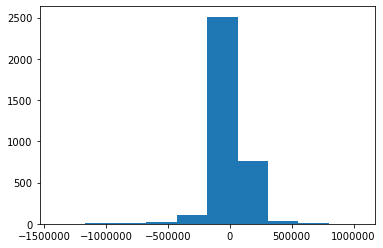

In [537]:
import matplotlib.pyplot as plt
plt.hist(y_hat  - y_test.price)

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


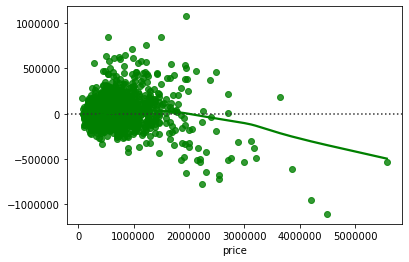

In [531]:
sns.residplot(y_test.price, y_hat, lowess=True, color='g')

In [507]:
from scipy.stats import sem

In [360]:
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
cross_val = (cross_val_score(estimator=lr, X=X, y=y, cv = 10))
cross_val_mean = round(np.mean(cross_val),2)
cross_val_std = round(np.std(cross_val),2)

standard_error = round(sem(cross_val), 2)

print(f"The RMSE of the current model is {RMSE} with a mean 10 fold cross validation score (R^2) of {cross_val_mean}, with a standard deviation of {cross_val_std} \
with a standard error of {standard_error}")

The RMSE of the current model is 134677.95 with a mean 10 fold cross validation score (R^2) of 0.84, with a standard deviation of 0.02 with a standard error of 0.01


## This is a very strong model! 

#### But we have a lot of features. We should widdle them down using RSE. 


### Feature Selection

In [362]:
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=100, step=1)
rfe = rfe.fit(X_train, y_train)
selected_rfe_features= pd.DataFrame({'Feature': list(X_train.columns),
                                    'Ranking': rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')[:100]

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Feature,Ranking
94,c23nd,1
235,98144,1
120,c23p6,1
118,c23p4,1
117,c23p3,1
...,...,...
1,c22vn,1
6,c22vu,1
7,c22vv,1
485,lat X yr_renovated,1


In [399]:
X_top_100 = X[selected_rfe_features.sort_values(by='Ranking').Feature.to_list()]

In [400]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_top_100, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [401]:
lr = LinearRegression()
lr.fit(X_train, y_train.price)
y_hat =lr.predict(X_test)
RMSE = mean_squared_error(y_test, y_hat)
RMSE**0.5

134748.08200853696

In [290]:
df = pd.read_csv('../raw/kc_holdout_data.csv', index_col=0)

to_drop = [
    'date', # handled as dummy columns/seasons
    'id', # randomly generated
    'zipcode', # handled as dummy columns
]
df.drop(columns=to_drop, inplace = True)

In [291]:
df.yr_built = df.yr_built.apply(lambda x: 2015-x)
df.yr_renovated = df.yr_renovated.apply(lambda x: 2015-x)

In [292]:
# impute the median beds and bad


In [300]:
df.sort_values('sqft_living', ascending = False)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
1012,5,6.25,8020,21738,2.0,0,0,3,11,8020,0,14,2015,47.5675,-122.189,4160,18969
2568,4,4.00,7850,89651,2.0,0,0,3,12,7850,0,9,2015,47.5406,-121.982,6210,95832
1187,8,4.00,7710,11750,3.5,0,0,5,12,6090,1620,111,2015,47.6263,-122.314,4210,8325
1304,5,4.00,7320,217800,2.0,0,0,3,11,7320,0,23,2015,47.4473,-122.086,3270,34500
4216,5,6.50,7270,130017,2.0,0,0,3,12,6420,850,5,2015,47.5371,-121.982,1800,44890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,1,0.75,480,9750,1.0,0,0,2,4,480,0,67,2015,47.4982,-122.362,1550,9924
762,1,1.00,460,4120,1.0,0,0,3,4,460,0,78,2015,47.4868,-122.199,990,4120
4042,1,1.00,390,2000,1.0,0,0,4,6,390,0,95,2015,47.6938,-122.347,1340,5100
1089,0,0.75,384,213444,1.0,0,0,3,4,384,0,12,2015,47.4177,-122.491,1920,224341


In [299]:
df.sqft_living.describe()

count    4323.000000
mean     2183.344899
std       966.768796
min       290.000000
25%      1452.000000
50%      2000.000000
75%      2730.000000
max      8020.000000
Name: sqft_living, dtype: float64

In [ ]:
holdout = pd.read_csv('../raw/kc_holdout_data.csv', index_col=0)

# create interaction dataframe

# drop columns we are not interested in
holdout.drop(columns=to_drop, inplace=True)

# Run the holdout dataframe through my function

holdout_interactions = get_interactions(holdout)

holdout_interactions.shape

# # test the model at scale
# holdout = pd.read_csv('../raw/kc_holdout_data.csv')
# # Get zipcode dummies 
# zipcodes_dummies = pd.get_dummies(holdout.zipcode)

to_drop = [
    'date', # handled as dummy columns/seasons
    'id', # randomly generated
    'zipcode', # handled as dummy columns
    'yr_renovated',

]
# get geo

### So the best we can do is 150K range, that has no feature normalization at all. How do we improve this?

holdoutZipcodes = pd.read_csv('../cleanedData/holdoutZipcodes.csv', index_col=0)
holdoutGeo = pd.read_csv('../cleanedData/holdoutGeo.csv', index_col=0)
holdoutSeason = pd.read_csv('../cleanedData/holdoutSeason.csv', index_col=0)
X_holdout = pd.read_csv('../raw/kc_holdout_data.csv', index_col=0)



holdout_df = pd.concat([X_holdout, holdoutGeo,holdoutZipcodes, holdoutSeason], axis=1)
holdout_df = holdout_df.drop(columns=to_drop)

hold_out_full = pd.concat([holdout_df,holdout_interactions], axis=1)

# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

X_train

lr = LinearRegression()
lr.fit(X, y)
y_hat =lr.predict(hold_out_full)
# RMSE = mean_squared_error(y, y_hat)

pd.DataFrame(y_hat).to_csv('../cleanedData/modeltwo.csv')

from sklearn.model_selection import cross_val_score
lr = LinearRegression()
(cross_val_score(estimator=lr, X=X_train, y=y_train, cv = 10))

pd.read_csv('../cleanedData/modeltwo.csv')